In [ ]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Reading images

In [2]:
import cv2

def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
im = read_image('/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry/tom/frame1153.jpg')
plt.imshow(im)

## Adding Noise to an Image

In [4]:
import numpy as np

def add_gaussian(img):
    mean = 0
    var = 10
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (img.shape[0],img.shape[1],img.shape[2]))
    noisy = img + gauss
    return noisy, gauss

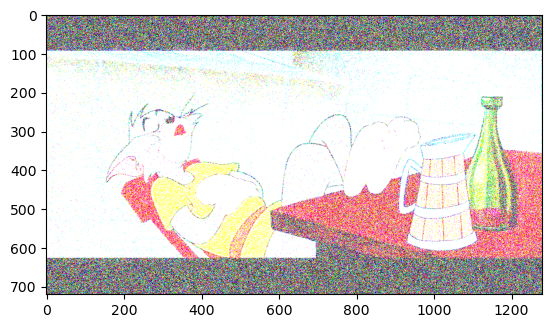

In [5]:
noisy_ims = {}
for i in range(0,100):
    im, gauss = add_gaussian(im)
    noisy_ims.update({i:[im, gauss]})
    
plt.imshow(noisy_ims[99][0])

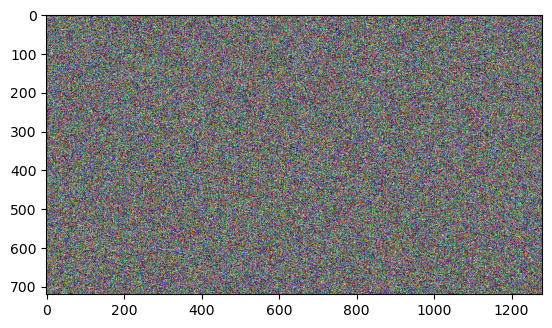

In [7]:
plt.imshow(noisy_ims[99][1])

## Preprocessing Images

In [6]:
import tensorflow as tf
import keras
import keras_cv
from keras_cv import layers as cv_layers

def assemble_image_dataset(files):

    # Resize images
    resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in files]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    images = images / 127.5 - 1


    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [7]:
import pandas as pd

df = pd.read_csv('/kaggle/input/tom-and-jerry-image-classification/ground_truth.csv')
tom_df = df[(df['tom']==1) & (df['jerry']==0)].sample(300)
base = '/kaggle/input/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry/'
base_tom = base + 'tom/'

tom_urls = [base_tom + f for f in tom_df['filename']]

tom_ds= assemble_image_dataset(tom_urls)
tom_ds

## Assemble a text dataset

In [10]:
stable_diffusion = keras_cv.models.StableDiffusion()

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [11]:
placeholder_token = '<tom-from-tom-and-jerry>'
MAX_PROMPT_LENGTH = 77


def pad_embedding(embedding):
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )

stable_diffusion.tokenizer.add_tokens(placeholder_token)


def assemble_text_dataset(prompts):
    prompts = [prompt.format(placeholder_token) for prompt in prompts]
    
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]
    
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    text_dataset = text_dataset.shuffle(100, reshuffle_each_iteration=True)
    return text_dataset

tom_prompts = [
    'An animated still from a cartoon containing {}',
    '{} trying to catch a mouse',
    'A two dimensional cartoon of {}',
    'A cartoon featuring {}',
    'An artists impression of {}',
    'A picture of {} surrounded by trees',
    'An animation featuring {} outside on a sunny day'
    '{} drawn by a cartoonist',
]

1356917/1356917 [==============================] - 0s 0us/step


## Combining the datasets
Combine the text prompts and images.

In [12]:
def assemble_dataset(files, prompts):
    image_dataset = assemble_image_dataset(files)
    text_dataset = assemble_text_dataset(prompts)
    image_dataset = image_dataset.repeat()

    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

In [13]:
tom_train_ds = assemble_dataset(tom_urls, tom_prompts)
train_ds = tom_train_ds
train_ds = train_ds.batch(1).shuffle(
    train_ds.cardinality(), reshuffle_each_iteration=True
)
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 77), dtype=tf.int64, name=None))>

## Adding the token

In [14]:
tokenized_initializer = stable_diffusion.tokenizer.encode("cat")[1]
new_weights = stable_diffusion.text_encoder.layers[2].token_embedding(
    tf.constant(tokenized_initializer)
)

new_vocab_size = len(stable_diffusion.tokenizer.vocab)

old_token_weights = stable_diffusion.text_encoder.layers[
    2
].token_embedding.get_weights()
old_position_weights = stable_diffusion.text_encoder.layers[
    2
].position_embedding.get_weights()

old_token_weights = old_token_weights[0]
new_weights = np.expand_dims(new_weights, axis=0)
new_weights = np.concatenate([old_token_weights, new_weights], axis=0)

492466864/492466864 [==============================] - 4s 0us/step


In [15]:
new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
    keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
    vocab_size=new_vocab_size,
    download_weights=False,
)
for index, layer in enumerate(stable_diffusion.text_encoder.layers):
    if index == 2:
        continue
    new_encoder.layers[index].set_weights(layer.get_weights())


new_encoder.layers[2].token_embedding.set_weights([new_weights])
new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

stable_diffusion._text_encoder = new_encoder
stable_diffusion._text_encoder.compile(jit_compile=True)

## Set trainable layers of the model

In [16]:
stable_diffusion.diffusion_model.trainable = False
stable_diffusion.decoder.trainable = False
stable_diffusion.text_encoder.trainable = True

stable_diffusion.text_encoder.layers[2].trainable = True


def traverse_layers(layer):
    if hasattr(layer, "layers"):
        for layer in layer.layers:
            yield layer
    if hasattr(layer, "token_embedding"):
        yield layer.token_embedding
    if hasattr(layer, "position_embedding"):
        yield layer.position_embedding


for layer in traverse_layers(stable_diffusion.text_encoder):
    if isinstance(layer, keras.layers.Embedding) or "clip_embedding" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

new_encoder.layers[2].position_embedding.trainable = False

198180272/198180272 [==============================] - 1s 0us/step


In [17]:
all_models = [
    stable_diffusion.text_encoder,
    stable_diffusion.diffusion_model,
    stable_diffusion.decoder,
]
print([[w.shape for w in model.trainable_weights] for model in all_models])

[[TensorShape([49409, 768])], [], []]


## Update the embedding

In [18]:
training_image_encoder = keras.Model(
    stable_diffusion.image_encoder.input,
    stable_diffusion.image_encoder.layers[-2].output,
)


def sample_from_encoder_outputs(outputs):
    mean, logvar = tf.split(outputs, 2, axis=-1)
    logvar = tf.clip_by_value(logvar, -30.0, 20.0)
    std = tf.exp(0.5 * logvar)
    sample = tf.random.normal(tf.shape(mean))
    return mean + std * sample


def get_timestep_embedding(timestep, dim=320, max_period=10000):
    half = dim // 2
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    return embedding


def get_position_ids():
    return tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

136824240/136824240 [==============================] - 4s 0us/step


In [19]:
class StableDiffusionFineTuner(keras.Model):
    def __init__(self, stable_diffusion, noise_scheduler, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.noise_scheduler = noise_scheduler

    def train_step(self, data):
        images, embeddings = data

        with tf.GradientTape() as tape:
            latents = sample_from_encoder_outputs(training_image_encoder(images))
            latents = latents * 0.18215

            noise = tf.random.normal(tf.shape(latents))
            batch_dim = tf.shape(latents)[0]


            timesteps = tf.random.uniform(
                (batch_dim,),
                minval=0,
                maxval=noise_scheduler.train_timesteps,
                dtype=tf.int64,
            )


            noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)


            encoder_hidden_state = self.stable_diffusion.text_encoder(
                [embeddings, get_position_ids()]
            )


            timestep_embeddings = tf.map_fn(
                fn=get_timestep_embedding,
                elems=timesteps,
                fn_output_signature=tf.float32,
            )


            noise_pred = self.stable_diffusion.diffusion_model(
                [noisy_latents, timestep_embeddings, encoder_hidden_state]
            )


            loss = self.compiled_loss(noise_pred, noise)
            loss = tf.reduce_mean(loss, axis=2)
            loss = tf.reduce_mean(loss, axis=1)
            loss = tf.reduce_mean(loss)

        trainable_weights = self.stable_diffusion.text_encoder.trainable_weights
        grads = tape.gradient(loss, trainable_weights)

        index_of_placeholder_token = tf.reshape(tf.where(grads[0].indices == 49408), ())
        condition = grads[0].indices == 49408
        condition = tf.expand_dims(condition, axis=-1)

        grads[0] = tf.IndexedSlices(
            values=tf.where(condition, grads[0].values, 0),
            indices=grads[0].indices,
            dense_shape=grads[0].dense_shape,
        )

        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        return {"loss": loss}

In [20]:
from keras_cv.models.stable_diffusion import NoiseScheduler

noise_scheduler = NoiseScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)
trainer = StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="trainer")
EPOCHS = 100
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)
optimizer = tf.keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=learning_rate, epsilon=1e-8, global_clipnorm=10
)

trainer.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(reduction="none"),
)

## Generating new images

In [21]:
class GenerateImages(keras.callbacks.Callback):
    def __init__(
        self, stable_diffusion, prompt, steps=50, frequency=10, seed=None, **kwargs
    ):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.prompt = prompt
        self.seed = seed
        self.frequency = frequency
        self.steps = steps

    def on_epoch_end(self, epoch, logs):
        if epoch % self.frequency == 50:
            images = self.stable_diffusion.text_to_image(
                self.prompt, batch_size=3, num_steps=self.steps, seed=self.seed
            )
            plot_images(
                images,
            )


cbs = [
    GenerateImages(
        stable_diffusion, prompt=f"{placeholder_token} building a house in the woods", seed=1337, frequency=25
    ),
    GenerateImages(
        stable_diffusion, prompt=f"An animation frame of {placeholder_token} in three dimensional animation style, photo-realistic", seed=1337, frequency=25
    ),
    GenerateImages(
        stable_diffusion,
        prompt=f"A high tech robotic version of {placeholder_token} flying through space, line drawn animation",
        seed=1337, frequency=25
    ),
]

In [22]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

## Train the model


In [ ]:
import math 

trainer.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=cbs,
)

## Testing

50/50 [==============================] - 74s 1s/step


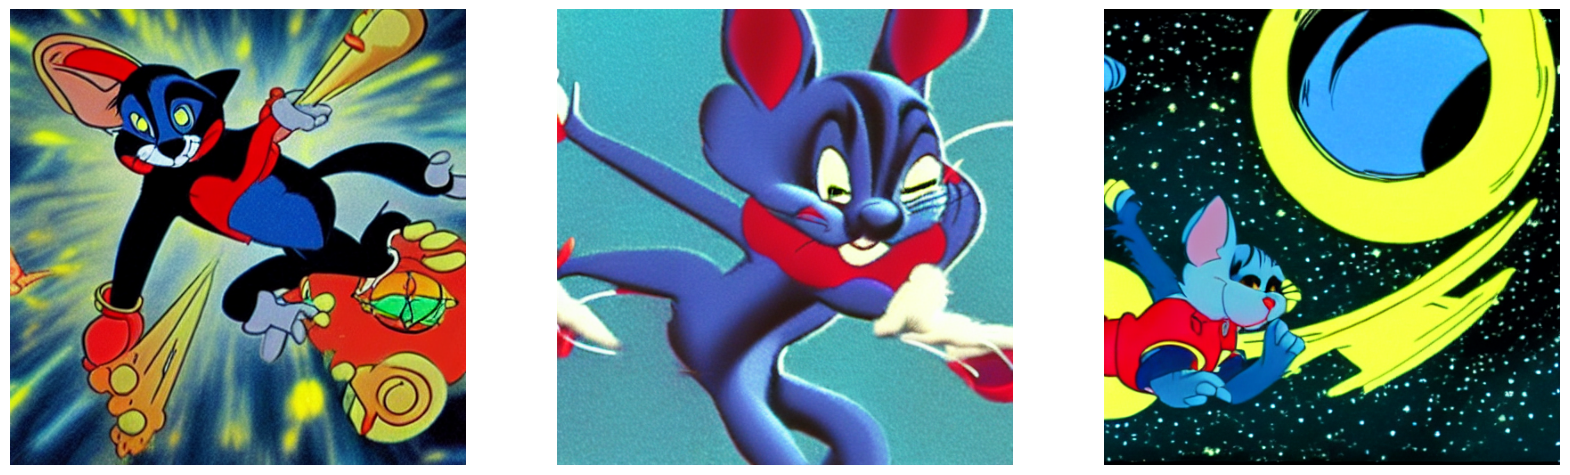

In [24]:
generated = stable_diffusion.text_to_image(
    f"A high tech robotic version of {placeholder_token} flying through space, line drawn animation",
    batch_size=3,
)
plot_images(generated)

50/50 [==============================] - 61s 1s/step


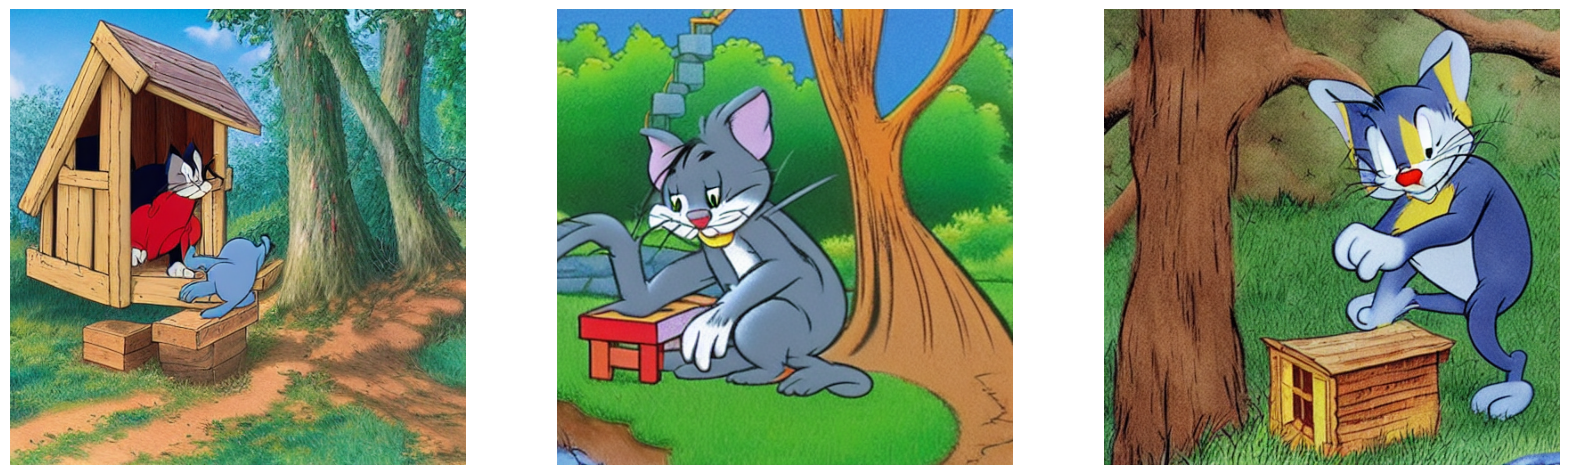

In [26]:
generated = stable_diffusion.text_to_image(
    f"{placeholder_token} building a house in the woods",
    batch_size=3,
)
plot_images(generated)

50/50 [==============================] - 62s 1s/step


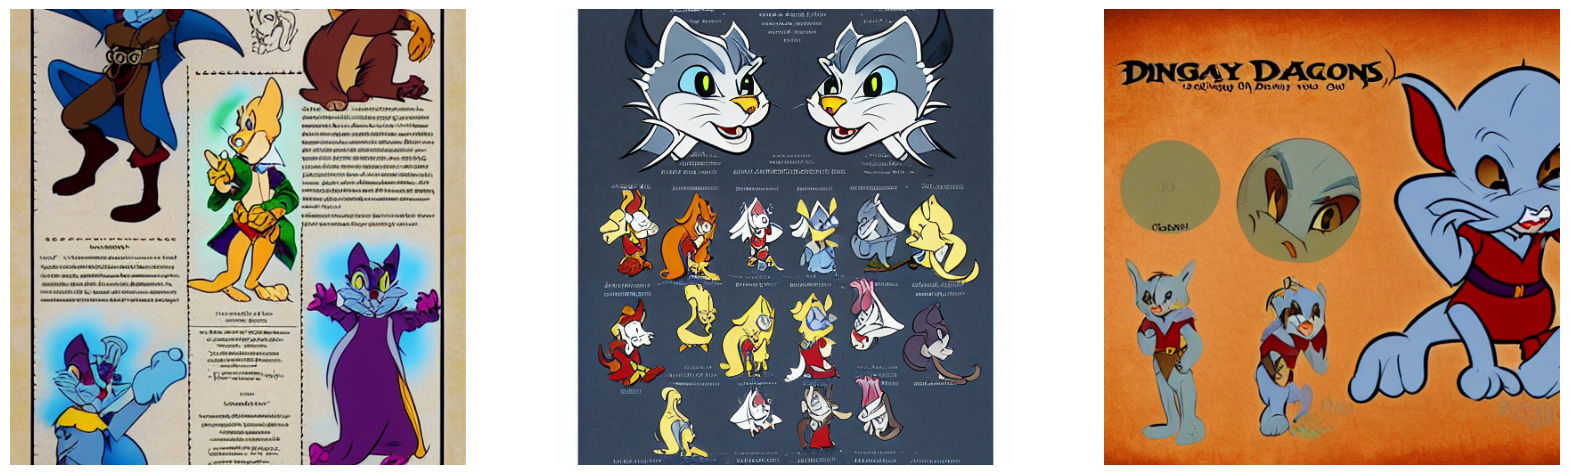

In [28]:
generated = stable_diffusion.text_to_image(
    f"A dungeons and dragons character sheet for {placeholder_token}",
    batch_size=3,
)
plot_images(generated)

50/50 [==============================] - 61s 1s/step


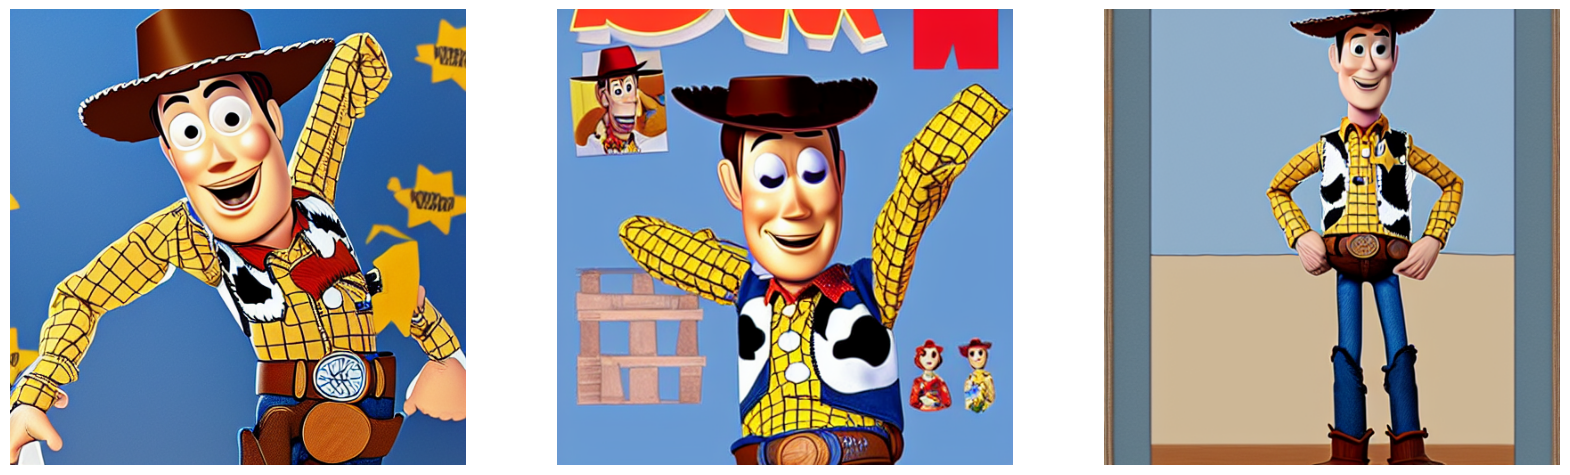

In [29]:
generated = stable_diffusion.text_to_image(
    f"Woody from Toy Story drawn in the same style as {placeholder_token} standing on a table",
    batch_size=3,
)
plot_images(generated)

50/50 [==============================] - 61s 1s/step


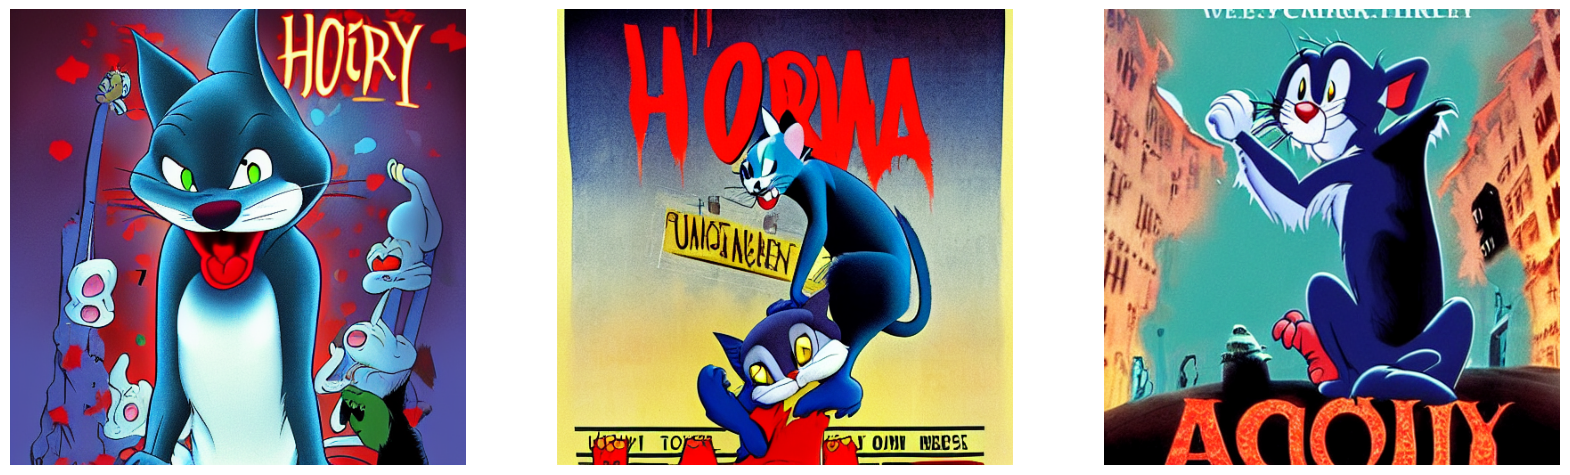

In [30]:
generated = stable_diffusion.text_to_image(
    f"A poster for a horror movie featuring {placeholder_token}",
    batch_size=3,
)
plot_images(generated)